# **Venue composition of top rated beer bars in Copenhagen**
## *Applied Data Science Capstone* Issued by Coursera



### **Introduction/ Business Problem**
If you have been working in the service industry, you have noticed that the success of a venue isn't entirely on what you can offer but in great part, the location. The venues around and how easy is to access would be a key factor to consider.

The aim of this project is to define the venue structure around the best rated beer bars in Copenhagen, Denmark. The insight might help to better decide in the future, a proper location to open a beer bar. 



### **Data**
The Data would be adquired using the Foursquare API. Firstly, it would be extracted the current data on Venues categorized as “Beer bars” in Copenhagen. Then, I would take the top 10 best rated ones and explore the neighboring venues, on a radius of 200 meters. The composition of the venues around the top bars would be analyzed and compared between them. 

### **Methods**

#### 1. Importing Libraries 

In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


Estoy usando la API de Foursquare y para hacer queries requiere que tengas una cuenta. Lo siguiente es mi ID para acceder.

#### 2. Using the Foursquare API to obtain all the "bar" venues in Copenhagen.

Setting the search query to request the data to Foursquare API:

In [ ]:
CLIENT_ID = 'RJPBQ4RM3LG331XLRL1W2TIIS0PDTCHWXXGXQGPPGTXLC0XD' # your Foursquare ID
CLIENT_SECRET = 'AA0LJWLADKRFLURPHQQIDB3YBV13M4V0XPKFRLVQUIGHCGVS' # your Foursquare Secret
VERSION = '20200706'
LIMIT = 1000 #limite de resultados
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RJPBQ4RM3LG331XLRL1W2TIIS0PDTCHWXXGXQGPPGTXLC0XD
CLIENT_SECRET:AA0LJWLADKRFLURPHQQIDB3YBV13M4V0XPKFRLVQUIGHCGVS


In [ ]:
address = 'Copenhagen, DK'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

55.6867243 12.5700724


Search query of "bar" venues in a radius of 10,000 meters around Copenhagen, Denmark:

In [ ]:
search_query = 'bar'
radius = 10000
print(search_query + ' .... OK!')

bar .... OK!


In [ ]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url 

'https://api.foursquare.com/v2/venues/search?client_id=RJPBQ4RM3LG331XLRL1W2TIIS0PDTCHWXXGXQGPPGTXLC0XD&client_secret=AA0LJWLADKRFLURPHQQIDB3YBV13M4V0XPKFRLVQUIGHCGVS&ll=55.6867243,12.5700724&v=20200706&query=bar&radius=10000&limit=1000'

In [ ]:
results = requests.get(url).json()
print(results['response']['venues'])

[{'id': '4b2436d9f964a520e66324e3', 'name': 'Harbo Bar', 'location': {'address': 'Blågårdsgade 2D', 'crossStreet': 'ved Nørrebrogade', 'lat': 55.687667929416556, 'lng': 12.559588135045614, 'labeledLatLngs': [{'label': 'display', 'lat': 55.687667929416556, 'lng': 12.559588135045614}], 'distance': 666, 'postalCode': '2200', 'cc': 'DK', 'city': 'København N', 'state': 'Region Hovedstaden', 'country': 'Danmark', 'formattedAddress': ['Blågårdsgade 2D (ved Nørrebrogade)', '2200 København N', 'Danmark']}, 'categories': [{'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593337079', 'hasPerk': False}, {'id': '4afd9d87f964a520192922e3', 'name': 'Ved Stranden 10 - Vinhandel & Bar', 'location': {'address': 'Ved Stranden 10', 'lat': 55.677262, 'lng': 12.58164, 'labeledLatLngs': [{'label': 'display', 'lat': 55.677262, 'lng': 12.5

In [ ]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood,venuePage.id
0,4b2436d9f964a520e66324e3,Harbo Bar,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1593337079,False,Blågårdsgade 2D,ved Nørrebrogade,55.687668,12.559588,"[{'label': 'display', 'lat': 55.68766792941655...",666,2200,DK,København N,Region Hovedstaden,Danmark,"[Blågårdsgade 2D (ved Nørrebrogade), 2200 Købe...",NaN,NaN
1,4afd9d87f964a520192922e3,Ved Stranden 10 - Vinhandel & Bar,"[{'id': '4bf58dd8d48988d123941735', 'name': 'W...",v-1593337079,False,Ved Stranden 10,NaN,55.677262,12.581640,"[{'label': 'display', 'lat': 55.677262, 'lng':...",1279,1061,DK,København K,Denmark,Danmark,"[Ved Stranden 10, 1061 København K, Danmark]",NaN,NaN
2,5380a41f498ebd1e825a3f54,Gorki Cafe Bar,"[{'id': '56aa371ce4b08b9a8d57356c', 'name': 'B...",v-1593337079,False,Nansensgade 26,NaN,55.681938,12.563078,"[{'label': 'display', 'lat': 55.6819379866084,...",690,1366,DK,København,Region Hovedstaden,Danmark,"[Nansensgade 26, 1366 København, Danmark]",NaN,NaN
3,4ed400760e61efa335402295,Bar Rouge Hotel Skt Petri,"[{'id': '4bf58dd8d48988d1d5941735', 'name': 'H...",v-1593337079,False,NaN,NaN,55.680871,12.572000,"[{'label': 'display', 'lat': 55.68087144153500...",662,NaN,DK,København,Region Hovedstaden,Danmark,"[København, Danmark]",NaN,NaN
4,4bdf0ac9be5120a162abfe70,Mikkeller Bar Viktoriagade,"[{'id': '56aa371ce4b08b9a8d57356c', 'name': 'B...",v-1593337079,False,Viktoriagade 8 B-C,NaN,55.671878,12.557791,"[{'label': 'display', 'lat': 55.671878, 'lng':...",1823,1655,DK,København,Region Hovedstaden,Danmark,"[Viktoriagade 8 B-C, 1655 København, Danmark]",NaN,NaN


The obtained dataframe shape:

In [ ]:
dataframe.shape

(50, 19)

### 3. Collecting their ratings

The following query generates the rating of one venue using their ID:

In [ ]:
venue_id = '4bdf0ac9be5120a162abfe70' # ID of Mikkeller bar at Viktoriagade
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
 
result_rating = requests.get(url).json()
try:
    print(result_rating['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

9.4


The following functions automate the process of retrieving the rating for each venue requested:


In [ ]:
def obtain_url(venue_id):
  url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
  return(url)

In [ ]:
def obtain_rating(venue_id):
  url = obtain_url(venue_id)
  result = requests.get(url).json()
  try:
    rat = result['response']['venue']['rating']
  except:
    rat = -1
  return(rat)

In [ ]:
dataframe.head().id.map(obtain_rating)

0    8.0
1    9.4
2    7.4
3   -1.0
4    9.4
Name: id, dtype: float64

In [ ]:
dataframe['rating'] = dataframe.id.map(obtain_rating)

In [ ]:
pd.value_counts(dataframe['rating'])

-1.0    22
 5.3     4
 8.3     3
 8.5     2
 9.4     2
 6.3     2
 7.6     2
 7.3     1
 4.6     1
 5.2     1
 4.9     1
 7.4     1
 7.9     1
 8.7     1
 8.1     1
 6.1     1
 6.4     1
 5.8     1
 4.7     1
 8.0     1
Name: rating, dtype: int64

In [ ]:
dataframe.dtypes

id                            object
name                          object
categories                    object
referralId                    object
hasPerk                         bool
location.address              object
location.crossStreet          object
location.lat                 float64
location.lng                 float64
location.labeledLatLngs       object
location.distance              int64
location.postalCode           object
location.cc                   object
location.city                 object
location.state                object
location.country              object
location.formattedAddress     object
location.neighborhood         object
venuePage.id                  object
rating                       float64
dtype: object

Removing the venues without rating:

In [ ]:
dataframe.drop(dataframe[dataframe.rating == -1].index, inplace=True)

In [ ]:
dataframe.shape

(28, 20)

Next we are going to drop the data that it's not of our interest:

In [ ]:
dataframe.reset_index(inplace=True,drop = True)

In [ ]:
dataframe.drop(['id', 'categories', 'referralId', 'hasPerk', 'location.labeledLatLngs', 'location.distance', 'location.cc', 'location.state', 
'location.country', 'location.formattedAddress', 'venuePage.id', 'location.crossStreet', 'location.neighborhood'], axis=1, inplace = True)


In [ ]:
df = dataframe.sort_values(by = 'rating', ascending = False)
df.reset_index(inplace=True,drop = True)

Let's look at the location data of the venues with their rating:

In [ ]:
df.head(10)

,name,location.address,location.lat,location.lng,location.postalCode,location.city,rating
0,Mikkeller Bar Viktoriagade,Viktoriagade 8 B-C,55.671878,12.557791,1655,København,9.4
1,Ved Stranden 10 - Vinhandel & Bar,Ved Stranden 10,55.677262,12.581640,1061,København K,9.4
2,Dürum Bar (Döner Kebab),Nørrebrogade 195,55.697283,12.544429,2200,København N,8.7
3,Lord Nelson Bar,Hyskenstræde 9,55.677972,12.576802,1207,København K,8.5
4,Democratic Coffee Bar,Krystalgade 15,55.680876,12.573507,1172,København,8.5
5,Bo-Bi Bar,Klareboderne 14,55.681134,12.578663,1115,København K,8.3
6,Berlin Bar,Gl. Kongevej 147,55.677131,12.538551,1850,Frederiksberg,8.3
7,K Bar,Ved Stranden 20,55.677774,12.580662,1061,København,8.3
8,Charlies Bar,Pilestræde 33,55.680717,12.580329,1112,København K,8.1
9,Harbo Bar,Blågårdsgade 2D,55.687668,12.559588,2200,København N,8.0


#### 4. Separating the venues by their rating into new categories

A new column will be created to group the venues according to their rating: 'low' rating venues are those from 0-7, 'middle' are those higher than 7 but 8 or lower, 'top' are venues higher than 8:

In [ ]:
rat_bins = [0,7,8,10]
rat_groups = ['low', 'middle', 'top']
level = pd.cut(df['rating'], rat_bins, labels = rat_groups)
          

In [ ]:
pd.value_counts(level)


low       13
top        9
middle     6
Name: rating, dtype: int64

In [ ]:
df['Level'] = level
df.head()

,name,location.address,location.lat,location.lng,location.postalCode,location.city,rating,Level
0,Mikkeller Bar Viktoriagade,Viktoriagade 8 B-C,55.671878,12.557791,1655,København,9.4,top
1,Ved Stranden 10 - Vinhandel & Bar,Ved Stranden 10,55.677262,12.581640,1061,København K,9.4,top
2,Dürum Bar (Döner Kebab),Nørrebrogade 195,55.697283,12.544429,2200,København N,8.7,top
3,Lord Nelson Bar,Hyskenstræde 9,55.677972,12.576802,1207,København K,8.5,top
4,Democratic Coffee Bar,Krystalgade 15,55.680876,12.573507,1172,København,8.5,top


Since two kebab restaurants appeared, they were removed via their index:

In [ ]:
df = df.drop(index= [2, 15], axis= 0)

#### 5. Data collection of venue composition


Defining a function to automatically collect the data of the venues in a radius of 100 meters around the beer bars.

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius_comp=100, limit_comp= 50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius_comp, 
            limit_comp)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Bar', 
                  'Bar Latitude', 
                  'Bar Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
clustering_venues = getNearbyVenues(names= df['name'],
                                   latitudes= df['location.lat'],
                                   longitudes= df['location.lng']
                                  )

Mikkeller Bar Viktoriagade
Ved Stranden 10 - Vinhandel & Bar
Lord Nelson Bar
Democratic Coffee Bar
Bo-Bi Bar
Berlin Bar
K Bar
Charlies Bar
Harbo Bar
Library Bar
PS Bar & Grill
Nimb Bar 'n' Grill
Gorki Cafe Bar
SALT Bar & Restaurant
Cosy Bar
Midtown Shisha Café and Bar
Ravnsborg kitchen and bar
Temple Bar
The Australian Bar
Hornsleth Bar
Hoppes Cafe & Bar
Benni's Bar
The South African Bar
Lobby Bar
Buddha Bar
LA Tequila Bar


Next, the shape of the data frame and the first 5 rows are shown

In [ ]:
print(clustering_venues.shape)
clustering_venues.head()

(230, 7)


,Bar,Bar Latitude,Bar Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mikkeller Bar Viktoriagade,55.671878,12.557791,Mikkeller Bar Viktoriagade,55.671878,12.557791,Beer Bar
1,Mikkeller Bar Viktoriagade,55.671878,12.557791,CoFoCo,55.671724,12.558512,Scandinavian Restaurant
2,Mikkeller Bar Viktoriagade,55.671878,12.557791,Grillen Burger Bar Vesterbrogade,55.672496,12.556700,Burger Joint
3,Mikkeller Bar Viktoriagade,55.671878,12.557791,Nam Thip,55.672209,12.557826,Thai Restaurant
4,Mikkeller Bar Viktoriagade,55.671878,12.557791,Dia’legd,55.672536,12.557371,Bar


The total of venues per bar:

In [ ]:
clustering_venues.groupby('Bar').count()

,Bar Latitude,Bar Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Bar,,,,,,
Benni's Bar,4,4,4,4,4,4
Berlin Bar,4,4,4,4,4,4
Bo-Bi Bar,7,7,7,7,7,7
Buddha Bar,17,17,17,17,17,17
Charlies Bar,14,14,14,14,14,14
Cosy Bar,20,20,20,20,20,20
Democratic Coffee Bar,3,3,3,3,3,3
Gorki Cafe Bar,4,4,4,4,4,4
Harbo Bar,13,13,13,13,13,13


In [ ]:
print('There are {} uniques categories.'.format(len(clustering_venues['Venue Category'].unique())))

There are 83 uniques categories.


#### 6. Analysis of Venue composition
The data is prepared into a one hot encoding to be able to analyze categorical data and use a machine learning algorithm for clustering.
The first 5 rows are shown:

In [ ]:
# one hot encoding
clus_onehot = pd.get_dummies(clustering_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
clus_onehot['Bar'] = clustering_venues['Bar']
# move neighborhood column to the first column
fixed_columns2 = [clus_onehot.columns[-1]] + list(clus_onehot.columns[:-1]) 

clus_onehot = clus_onehot[fixed_columns2]

clus_onehot.head()

,Yoga Studio,Art Gallery,Asian Restaurant,Australian Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Bookstore,Breakfast Spot,Burger Joint,Café,Cajun / Creole Restaurant,Candy Store,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Creperie,Cupcake Shop,Department Store,Dessert Shop,Dive Bar,Dumpling Restaurant,Farmers Market,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gay Bar,Gluten-free Restaurant,Gourmet Shop,Grocery Store,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,...,Library,Lounge,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Miscellaneous Shop,Movie Theater,Music Venue,Pedestrian Plaza,Pharmacy,Pizza Place,Planetarium,Plaza,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Scandinavian Restaurant,Seafood Restaurant,Shoe Store,South Indian Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,Mikkeller Bar Viktoriagade,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,Mikkeller Bar Viktoriagade,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,Mikkeller Bar Viktoriagade,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,Mikkeller Bar Viktoriagade,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,Mikkeller Bar Viktoriagade,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Normalization of data:

In [ ]:
clus_grouped = clus_onehot.groupby('Bar').mean().reset_index()
clus_grouped

,Bar,Yoga Studio,Art Gallery,Asian Restaurant,Australian Restaurant,Bakery,Beer Bar,Beer Garden,Bookstore,Breakfast Spot,Burger Joint,Café,Cajun / Creole Restaurant,Candy Store,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Creperie,Cupcake Shop,Department Store,Dessert Shop,Dive Bar,Dumpling Restaurant,Farmers Market,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gay Bar,Gluten-free Restaurant,Gourmet Shop,Grocery Store,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,...,Library,Lounge,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Miscellaneous Shop,Movie Theater,Music Venue,Pedestrian Plaza,Pharmacy,Pizza Place,Planetarium,Plaza,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Scandinavian Restaurant,Seafood Restaurant,Shoe Store,South Indian Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Benni's Bar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.0,0.000000,0.25,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Berlin Bar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.25,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bo-Bi Bar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.00,0.142857,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Buddha Bar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.058824,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.058824,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000,0.00,0.000000,0.000000,0.058824,0.0,0.058824,0.000000,0.058824,0.00,0.058824,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.058824,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.058824,0.000000,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.058824,0.000000,0.000000
4,Charlies Bar,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.071429,0.142857,0.000000,0.071429,0.0,0.00000

In [ ]:
# clus_grouped join #only through clus_grouped['Bar'] con top_bars['name'] axis = 0, 
#  pd.concat([clus_grouped, top_bars['name']], axis=1, join='inner')
### Este podría ser el bueno:
# top_bars_sts = pd.merge(clus_grouped, top_bars['Bar'], on= ['name', 'Bar'], how= inner, axis= 1)

In [ ]:
#  New_df = pd.merge(df1, df2['column1', 'otra_info'], left_on = 'column_df1' , right_on = 'column1' , how= inner)

In [ ]:
clus_grouped.describe()


,Yoga Studio,Art Gallery,Asian Restaurant,Australian Restaurant,Bakery,Beer Bar,Beer Garden,Bookstore,Breakfast Spot,Burger Joint,Café,Cajun / Creole Restaurant,Candy Store,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Creperie,Cupcake Shop,Department Store,Dessert Shop,Dive Bar,Dumpling Restaurant,Farmers Market,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gay Bar,Gluten-free Restaurant,Gourmet Shop,Grocery Store,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Jazz Club,...,Library,Lounge,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Miscellaneous Shop,Movie Theater,Music Venue,Pedestrian Plaza,Pharmacy,Pizza Place,Planetarium,Plaza,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Scandinavian Restaurant,Seafood Restaurant,Shoe Store,South Indian Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000,25.000000,25.000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000,25.000,25.000000,25.000000,25.000000,25.000,25.000000,25.000000,25.000000,25.00,25.000000,25.000000,25.000000,...,25.000000,25.000000,25.000,25.000000,25.000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000,25.000000,25.00,25.00,25.000000,25.000000,25.000000,25.00,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.003333,0.008333,0.007714,0.003333,0.008797,0.020444,0.020000,0.01,0.004353,0.025449,0.059401,0.003077,0.008571,0.048016,0.040635,0.057972,0.004,0.008667,0.002,0.002857,0.003333,0.005714,0.005430,0.004444,0.002353,0.018444,0.002353,0.005,0.002,0.008667,0.004444,0.014575,0.004,0.043561,0.004444,0.002353,0.01,0.002353,0.012778,0.006190,...,0.013333,0.022444,0.002,0.008571,0.004,0.005714,0.004444,0.003333,0.008333,0.012353,0.017176,0.008,0.023464,0.01,0.01,0.013111,0.002353,0.059683,0.01,0.011429,0.002353,0.007302,0.014190,0.004444,0.008889,0.004,0.008507,0.002353,0.008571,0.006353,0.004706,0.006667,0.003333,0.015111,0.005333,0.008571,0.002353,0.030951,0.008067,0.010686
std,0.016667,0.029463,0.021618,0.016667,0.026118,0.056604,0.069222,0.05,0.015120,0.046792,0.123364,0.015385,0.031407,0.083038,0.110983,0.092172,0.020,0.034400,0.010,0.014286,0.016667,0.028571,0.018974,0.022222,0.011765,0.044983,0.011765,0.025,0.010,0.034400,0.022222,0.035228,0.020,0.106983,0.022222,0.011765,0.05,0.011765,0.035843,0.021495,...,0.066667,0.055705,0.010,0.031407,0.020,0.019778,0.022222,0.016667,0.029463,0.050886,0.036398,0.040,0.062021,0.05,0.05,0.039961,0.011765,0.094340,0.05,0.033756,0.011765,0.025912,0.044259,0.022222,0.030765,0.020,0.032481,0.011765,0.031407,0.022777,0.016287,0.033333,0.016667,0.043019,0.019076,0.023690,0.011765,0.061321,0.022395,0.031074
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Bar']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
clus_venues_sorted1 = pd.DataFrame(columns=columns)
clus_venues_sorted1['Bar'] = clus_grouped['Bar']

for ind in np.arange(clus_grouped.shape[0]):
    clus_venues_sorted1.iloc[ind, 1:] = return_most_common_venues(clus_grouped.iloc[ind, :], num_top_venues)


clus_venues_sorted1.rename(columns = {'Bar': 'name'}, inplace= True)
clus_venues_sorted1.head()

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Benni's Bar,Ramen Restaurant,Beer Garden,Cocktail Bar,Pharmacy,Women's Store,Gay Bar,Farmers Market,Food & Drink Shop,French Restaurant,Fried Chicken Joint
1,Berlin Bar,Indian Restaurant,Record Shop,Beer Garden,Women's Store,Gay Bar,Dumpling Restaurant,Farmers Market,Food & Drink Shop,French Restaurant,Fried Chicken Joint
2,Bo-Bi Bar,Tea Room,Men's Store,Shoe Store,Clothing Store,Candy Store,Dive Bar,Hotel,Ice Cream Shop,Dumpling Restaurant,Indian Restaurant
3,Buddha Bar,Coffee Shop,Tapas Restaurant,Ice Cream Shop,Hotel,Grocery Store,Fried Chicken Joint,Plaza,South Indian Restaurant,Café,Burger Joint
4,Charlies Bar,Clothing Store,Juice Bar,Tea Room,Wine Shop,Men's Store,Miscellaneous Shop,Shoe Store,Coffee Shop,Candy Store,Scandinavian Restaurant


#### 7. Machine Learning time: K-means

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
clus_grouped_clustering = clus_grouped.drop('Bar', 1)

In [ ]:
# Standardize the data
X_std = StandardScaler().fit_transform(clus_grouped_clustering)

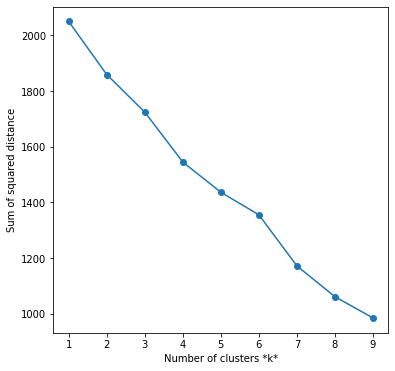

In [ ]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [ ]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clus_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 2, 2, 2, 1, 1, 2, 2], dtype=int32)

In [ ]:
# add clustering labels
clus_venues_sorted1.insert(0, 'Cluster Labels', kmeans.labels_)

final_merged = df

final_merged = final_merged.join(clus_venues_sorted1.set_index('name'), on='name')

final_merged.head()


,name,location.address,location.lat,location.lng,location.postalCode,location.city,rating,Level,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mikkeller Bar Viktoriagade,Viktoriagade 8 B-C,55.671878,12.557791,1655,København,9.4,top,2.0,Scandinavian Restaurant,Convenience Store,Beer Bar,Hostel,Middle Eastern Restaurant,Thai Restaurant,Burger Joint,Szechuan Restaurant,Women's Store,Gay Bar
1,Ved Stranden 10 - Vinhandel & Bar,Ved Stranden 10,55.677262,12.581640,1061,København K,9.4,top,2.0,Scandinavian Restaurant,Wine Bar,Lounge,Coffee Shop,Steakhouse,Furniture / Home Store,Dive Bar,Dumpling Restaurant,Farmers Market,Food & Drink Shop
3,Lord Nelson Bar,Hyskenstræde 9,55.677972,12.576802,1207,København K,8.5,top,2.0,Women's Store,Scandinavian Restaurant,Art Gallery,Australian Restaurant,Coffee Shop,Dessert Shop,Italian Restaurant,Jazz Club,Pedestrian Plaza,Yoga Studio
4,Democratic Coffee Bar,Krystalgade 15,55.680876,12.573507,1172,København,8.5,top,1.0,Café,Library,Coffee Shop,Women's Store,Farmers Market,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gay Bar
5,Bo-Bi Bar,Klareboderne 14,55.681134,12.578663,1115,København K,8.3,top,2.0,Tea Room,Men's Store,Shoe Store,Clothing Store,Candy Store,Dive Bar,Hotel,Ice Cream Shop,Dumpling Restaurant,Indian Restaurant


#### 8. Venue composition of top-rated bars


In [ ]:
top_bars = final_merged[final_merged['rating'] > 8]
top_bars =top_bars.drop(['location.address', 'location.lat', 'location.lng', 'location.postalCode', 'location.city', 'rating', 'Level', 'Cluster Labels'], axis = 'columns')
 
top_bars

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mikkeller Bar Viktoriagade,Scandinavian Restaurant,Convenience Store,Beer Bar,Hostel,Middle Eastern Restaurant,Thai Restaurant,Burger Joint,Szechuan Restaurant,Women's Store,Gay Bar
1,Ved Stranden 10 - Vinhandel & Bar,Scandinavian Restaurant,Wine Bar,Lounge,Coffee Shop,Steakhouse,Furniture / Home Store,Dive Bar,Dumpling Restaurant,Farmers Market,Food & Drink Shop
3,Lord Nelson Bar,Women's Store,Scandinavian Restaurant,Art Gallery,Australian Restaurant,Coffee Shop,Dessert Shop,Italian Restaurant,Jazz Club,Pedestrian Plaza,Yoga Studio
4,Democratic Coffee Bar,Café,Library,Coffee Shop,Women's Store,Farmers Market,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gay Bar
5,Bo-Bi Bar,Tea Room,Men's Store,Shoe Store,Clothing Store,Candy Store,Dive Bar,Hotel,Ice Cream Shop,Dumpling Restaurant,Indian Restaurant
6,Berlin Bar,Indian Restaurant,Record Shop,Beer Garden,Women's Store,Gay Bar,Dumpling Restaurant,Farmers Market,Food & Drink Shop,French Restaurant,Fried Chicken Joint
7,K Bar,Scandinavian Restaurant,Wine Bar,Restaurant,Lounge,Plaza,Coffee Shop,Fried Chicken Joint,Dive Bar,Dumpling Restaurant,Farmers Market
8,Charlies Bar,Clothing Store,Juice Bar,Tea Room,Wine Shop,Men's Store,Miscellaneous Shop,Shoe Store,Coffee Shop,Candy Store,Scandinavian Restaurant


In [ ]:
final_merged.dropna(axis=0, inplace = True)
final_merged.shape

(22, 19)

In [ ]:
final_merged['Cluster Labels'] = final_merged['Cluster Labels'].astype(int)

# Comparing the three different rating levels: 'top' 'middle' and 'low' with the obtained Cluster labels.


In [ ]:
showtime = final_merged[['name', 'Level', 'Cluster Labels']]
showtime

,name,Level,Cluster Labels
0,Mikkeller Bar Viktoriagade,top,2
1,Ved Stranden 10 - Vinhandel & Bar,top,2
3,Lord Nelson Bar,top,2
4,Democratic Coffee Bar,top,1
5,Bo-Bi Bar,top,2
6,Berlin Bar,top,0
7,K Bar,top,2
8,Charlies Bar,top,2
9,Harbo Bar,middle,2
10,Library Bar,middle,2


# 3. Visualizing venues in a map



In [ ]:
address = 'Copenhagen, DK'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

55.6867243 12.5700724


In [ ]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [ ]:
map_cph1 = folium.Map(location=[latitude, longitude], zoom_start=12.5)
 
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
 
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_merged['location.lat'], final_merged['location.lng'], 
                                  final_merged['name'], final_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True) 

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= rainbow[cluster-1],
        fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(map_cph1)       
map_cph1

In [ ]:
map_cph2 = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# set color scheme for the clusters
def colorin(Level):
  if Level == 'top':
    return 'red'
  elif Level == 'middle':
    return 'orange'
  else:
    return 'blue'

# add markers to the map
markers_colors = []
for lat, lon, poi, lvl in zip(final_merged['location.lat'], final_merged['location.lng'], 
                                  final_merged['name'], final_merged['Level']):
    label = folium.Popup(str(poi) + ' Level ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colorin(lvl),
        fill=True,
        fill_color= colorin(lvl),
        fill_opacity=0.7).add_to(map_cph2)

map_cph2



